In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delivery/historical_data (1).csv
/kaggle/input/delivery/predict_data (1).csv


In [2]:
"""Author: Demet Tunali"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [3]:
import scipy.stats as stats
def ChiSquaredTestOfIndependence( df, inputVar, Outcome_Category ):
    # Useful to have this wrapped in a function
    # The ChiSquaredTest of Independence - 
    # has a null hypothesis: the OutcomeCategory is independent of the inputVar
    # So we create a test-statistic which is a measure of the difference between 
    # "expected" i.e. what we WOULD observe if the OutcomeCategory WAS independent of the inputVar
    # "observed" i.e. what the data actually shows
    # the p-value returned is the probability of seeing this test-statistic if the null-hypothesis is true
    Outcome_Category_Table = df.groupby( Outcome_Category )[ Outcome_Category ].count().values
    Outcome_Category_Ratios = Outcome_Category_Table / sum( Outcome_Category_Table )
    possibleVals = df[inputVar].unique()
    observed = []
    expected = []
    for possible in possibleVals:
        countsInCategories = df[ df[ inputVar ] == possible ].groupby( Outcome_Category )[Outcome_Category].count().values
        if( len(countsInCategories) != len( Outcome_Category_Ratios ) ):
            print("Error! The class " + str( possible) +" of \'" + inputVar + "\' does not contain all values of \'" + Outcome_Category + "\'" )
            return
        elif( min(countsInCategories) < 5 ):
            print("Chi Squared Test needs at least 5 observations in each cell!")
            print( inputVar + "=" + str(possible) + " has insufficient data")
            print( countsInCategories )
            return
        else:
            observed.append( countsInCategories )   
            expected.append( Outcome_Category_Ratios * len( df[df[ inputVar ] == possible ]))
    observed = np.array( observed )
    expected = np.array( expected )
    chi_squared_stat = ((observed - expected)**2 / expected).sum().sum()
    degOfF = (observed.shape[0] - 1 ) *(observed.shape[1] - 1 ) 
    #crit = stats.chi2.ppf(q = 0.95,df = degOfF) 
    p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=degOfF)
    print("Calculated test-statistic is %.2f" % chi_squared_stat )
    print("If " + Outcome_Category + " is indep of " + inputVar + ", this has prob %.2e of occurring" % p_value )

In [334]:
"""Get to know the content of the data"""

df = pd.read_csv("../input/delivery/historical_data (1).csv")
submission = pd.read_csv("../input/delivery/predict_data (1).csv")

"""#Create the target variable
import datetime
df['actual_delivery_time']=df['actual_delivery_time'].astype('datetime64[ns]')
df['created_at']=df['created_at'].astype('datetime64[ns]')
df['delivery_time']=(df['actual_delivery_time']-df['created_at']).astype('timedelta64[s]')
"""

print(df.head())
print("Dataset's shape:", df.shape)

#See the type of the columns and unique 
#categories if there are object type columns
print(df.dtypes.value_counts())


#df.info()
#All id variables are numeric. Transform them to bins


   market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1       

In [335]:
"""Replace negative numerical values with NAN, including id variables"""

cols_numeric_anomalies= [ f for f in df.columns if df.dtypes[ f ] != "object"]
print(cols_numeric_anomalies)
"""to_drop_anomalies=['market_id', 'created_at', 'actual_delivery_time']
for f in to_drop_anomalies:
    cols_numeric_anomalies.remove(f)
print(cols_numeric_anomalies)"""
print(df[cols_numeric_anomalies].lt(0).sum())

for var in cols_numeric_anomalies:
    df.loc[~(df[var] > 0), var]=np.nan
    
print(df[cols_numeric_anomalies].lt(0).sum())

['market_id', 'store_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']
market_id                                        0
store_id                                         0
order_protocol                                   0
total_items                                      0
subtotal                                         0
num_distinct_items                               0
min_item_price                                  13
max_item_price                                   0
total_onshift_dashers                           21
total_busy_dashers                              21
total_outstanding_orders                        44
estimated_order_place_duration                   0
estimated_store_to_consumer_driving_duration     0
dtype: int64
market_id                             

In [336]:
"""Preliminary steps"""

#Drop duplicates using cols_unique as identifier. No missing value observed simulteneously in these columns
df = df.sort_values(["store_id", "created_at"], ascending = (True, True))
print("original shape is: ", df.shape)
cols_unique=['store_id','created_at']
df_nodup = df.drop_duplicates(subset=cols_unique, keep='first')
print("df_nodup shape is: ", df_nodup.shape)

#fill in missing values via assumptions
cols_aux_1=[ "store_id", "created_at","store_primary_category"]
cols_aux_2=["market_id", "store_primary_category"]
#df_nodup["store_id_aux"]=df_nodup["store_id"]
#df_nodup["market_id_aux"]=df_nodup["market_id"]
#df_aux_0.rename("store_id_aux")
df_aux_1=df_nodup[cols_aux_1]
#df_aux_2=pd.concat([df_aux_1, df_aux_0], axis=1)
df_aux_1=df_aux_1.sort_values(["store_id", "created_at"], ascending = (True, True))
#df_aux_1_storeid=df_aux_1.groupby("store_id").first().reset_index()
df_aux_storeid=df_aux_1.groupby(['store_id'])['store_primary_category'].first().to_frame(name='store_cat_first').reset_index()


"""#Assume that market_id&store_id is a unique combination as well. For example, there is a separate store_id for Chipotle in two separate markets
df_aux_2=df_nodup[cols_aux_2]
from scipy import stats
modes=df_aux_2.groupby('market_id').agg(lambda x: stats.mode(x)[0][0]).reset_index()
df_aux_2['store_cat_mode'] = df_aux_2['market_id'].map(modes.set_index('market_id')['store_primary_category'])
#df_aux_1_marketid=df_aux_1.groupby("market_id").first().reset_index()
#df_aux_1_storeid.loc[df_aux_1_storeid["store_id"]==5477]
#df_aux_1_2=df_aux_1.groupby("market_id").mode()
#df_aux_2.head()
#df_aux_2[df_aux_2.market_id.isnull()]
#df_aux_2.drop('store_primary_category')
#df_aux_2.pop('store_primary_category')
#print(df_aux_2.head())
#df_nodup_exp = pd.merge(df_nodup_exp, df_aux_2, on="market_id", how="left")
"""
df_nodup = pd.merge(df_nodup, df_aux_storeid, on="store_id", how="left")
#df_nodup = pd.merge(df_nodup, df_aux_storeid, on="store_id", how="left")
df_nodup.pop('store_cat_first')


original shape is:  (197428, 16)
df_nodup shape is:  (197255, 16)


0          mexican
1          mexican
2          mexican
3          mexican
4          mexican
            ...   
197250        fast
197251        fast
197252        fast
197253    american
197254    american
Name: store_cat_first, Length: 197255, dtype: object

In [337]:
"""Create new variables """
df_nodup.total_onshift_dashers.describe()
df_nodup.total_outstanding_orders.describe()
#df_nodup.loc[df_nodup.total_onshift_dashers<0,"total_onshift_dashers"] = 0
#df_nodup.loc[df_nodup.total_outstanding_orders<0,"total_outstanding_orders"] = 0

df_nodup['available_dashers']=(df_nodup['total_onshift_dashers']-df_nodup['total_busy_dashers'])
df_nodup.loc[df_nodup.available_dashers<0,"available_dashers"] = np.nan
df_nodup['available_dashers_pct']=(df_nodup['available_dashers']/df_nodup['total_onshift_dashers'])
df_nodup.loc[df_nodup.total_onshift_dashers==0,"available_dashers_pct"] = 0
df_nodup['dashers_to_order']=(df_nodup['available_dashers']/df_nodup['total_outstanding_orders'])
df_nodup.loc[df_nodup.total_outstanding_orders==0,"dashers_to_order"] = 0
df_nodup=df_nodup.drop(columns='available_dashers')

df_nodup['share_distinct_items']=(df_nodup['num_distinct_items']/df_nodup['total_items'])

import datetime
df_nodup['actual_delivery_time']=df_nodup['actual_delivery_time'].astype('datetime64[ns]')
df_nodup['created_at']=df_nodup['created_at'].astype('datetime64[ns]')
df_nodup['delivery_time']=(df_nodup['actual_delivery_time']-df_nodup['created_at']).astype('timedelta64[s]')
df_nodup['delivery_time_ln']=np.log(df_nodup['delivery_time'])
df_nodup['created_mth']=df_nodup['created_at'].dt.month
df_nodup['created_weekday']=df_nodup['created_at'].dt.weekday
df_nodup=df_nodup.drop(columns='delivery_time')

"""Observation: delivery time range is too big. When outliers for delivery time is removed, after minmax-transformation, there was no relationship among variables"""



'Observation: delivery time range is too big. When outliers for delivery time is removed, after minmax-transformation, there was no relationship among variables'

In [305]:

df_nodup.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'available_dashers_pct',
       'dashers_to_order', 'share_distinct_items', 'delivery_time_ln',
       'created_mth', 'created_weekday'],
      dtype='object')

In [338]:

"""Define column lists and format columns"""

categorical=['store_primary_category', 'market_id', 'order_protocol', 'created_mth', 'created_weekday']
other=['created_at','actual_delivery_time', 'store_id' ]

cols_numeric_univariate= [ f for f in df_nodup.columns if df_nodup.dtypes[ f ] != "object"]
to_drop_numerical=cols_numeric_univariate
for f in (categorical[1:]+other):
    cols_numeric_univariate.remove(f)
print(cols_numeric_univariate)

#To use for Label Encoding 
for var in (categorical+['store_id']):
    df_nodup[var]=df_nodup[var].astype('category')
df_nodup.info()

['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'available_dashers_pct', 'dashers_to_order', 'share_distinct_items', 'delivery_time_ln']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 197255 entries, 0 to 197254
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196268 non-null  category      
 1   created_at                                    197255 non-null  datetime64[ns]
 2   actual_delivery_time                          197248 non-null  datetime64[ns]
 3   store_id                                      197255 non-null  category      
 4   store_primary_category                        192497 n

'some skewed variables'

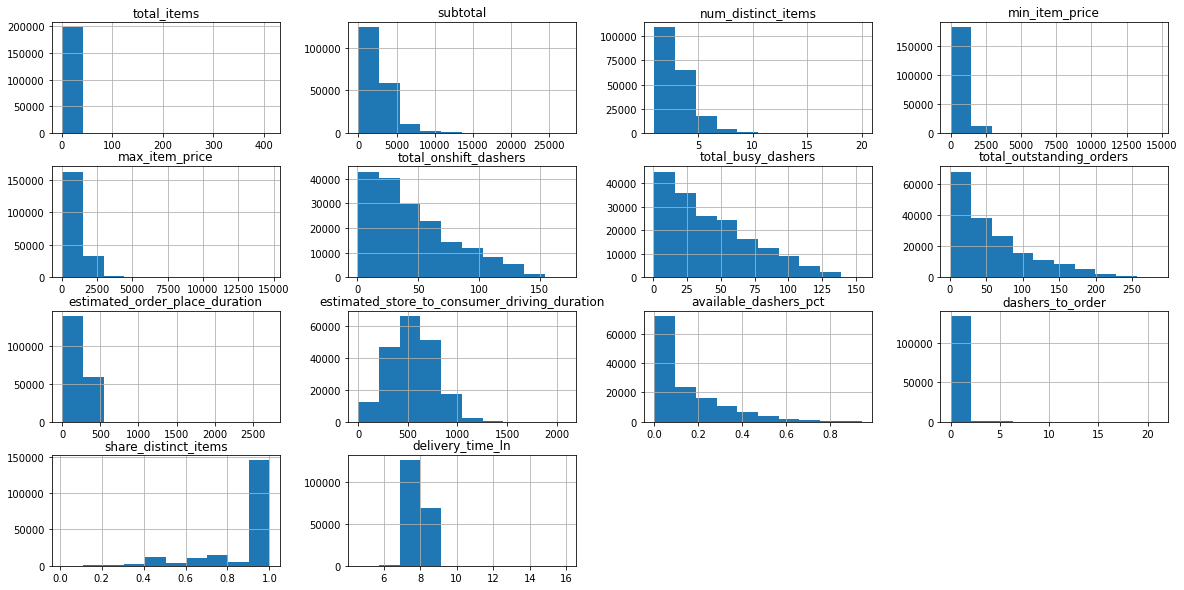

In [331]:
"""See numerical variables"""
df_nodup[cols_numeric_univariate].hist(figsize=(20, 10));
plt.savefig('file_name2.png')
plt.title('Correlation Heatmap');
"some skewed variables"

In [339]:
cols_numeric_univariate

['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'available_dashers_pct',
 'dashers_to_order',
 'share_distinct_items',
 'delivery_time_ln']

In [340]:
"share_distinct_items trims too many observations"

#backup_cols.remove('share_distinct_items')
df_copy_nodup=df_nodup
#backup_cols=['total_items', 'subtotal']
from scipy import stats
print("original shape is: ",df_nodup.shape )
for var in cols_numeric_univariate:
    print("var is: ", var)
    if var != 'share_distinct_items':
        IQR = stats.iqr(df_copy_nodup[var], interpolation = 'midpoint', nan_policy='omit')
        Q1=df_copy_nodup[var].quantile(0.25)
        Q3=df_copy_nodup[var].quantile(0.75)
        Lower_Whisker = Q1-(1.5)*IQR
        Upper_Whisker = Q3+(1.5)*IQR
        print("Q3 is: ", Q3)    
        print("IQR_fnc is: ", IQR)
        print("Upper_Whisker is: ", Upper_Whisker)
        print("outlier sum is: ", (df_copy_nodup[var]>Upper_Whisker).sum()    )
        df_copy_nodup=df_copy_nodup[~((df_copy_nodup[var]<Lower_Whisker) | (df_copy_nodup[var]>Upper_Whisker))]
        print(df_copy_nodup['share_distinct_items'].describe())
        #df_nodup = df_nodup[df_nodup[var]< Upper_Whisker]
    
print("new shape is: ",df_nodup.shape )
print("df_copy_nodup shape is: ",df_copy_nodup.shape )
#print("Approximately 23% of the data is trimmed")
        
    
    
    

original shape is:  (197255, 22)
var is:  total_items
Q3 is:  4.0
IQR_fnc is:  2.0
Upper_Whisker is:  7.0
outlier sum is:  9580
count    187675.000000
mean          0.916953
std           0.166616
min           0.142857
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: share_distinct_items, dtype: float64
var is:  subtotal
Q3 is:  3235.0
IQR_fnc is:  1840.0
Upper_Whisker is:  5995.0
outlier sum is:  6505
count    181170.000000
mean          0.918958
std           0.165738
min           0.142857
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: share_distinct_items, dtype: float64
var is:  num_distinct_items
Q3 is:  3.0
IQR_fnc is:  2.0
Upper_Whisker is:  6.0
outlier sum is:  653
count    180517.000000
mean          0.918665
std           0.165966
min           0.142857
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: share_distinct_items, dtyp

'Conclusion:'

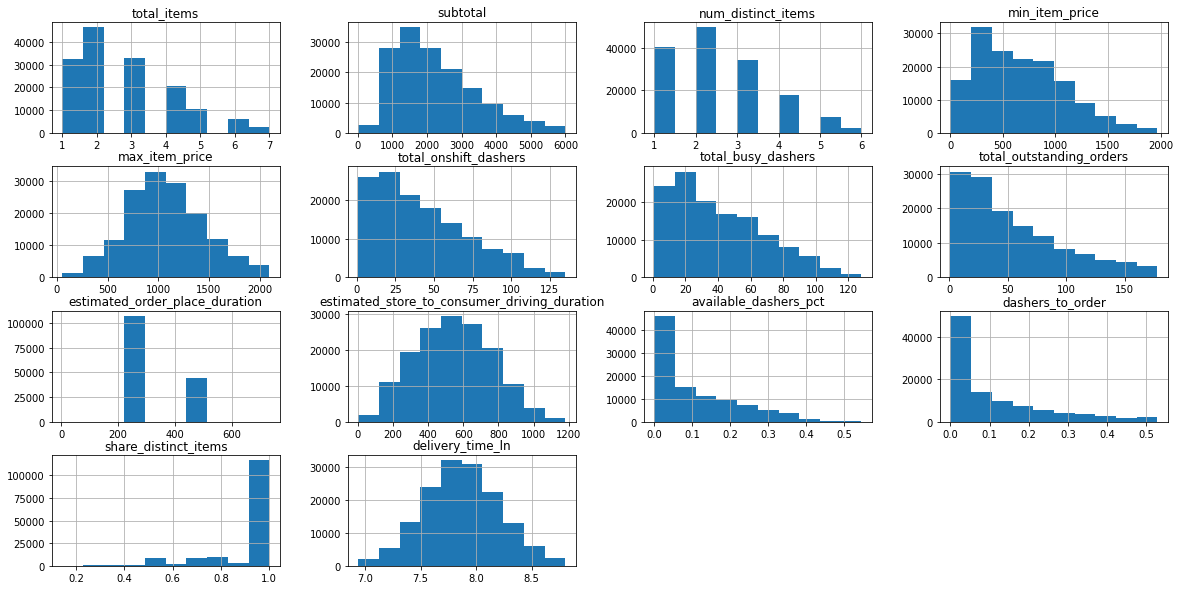

In [282]:
"""See numerical variables"""
df_copy_nodup[cols_numeric_univariate].hist(figsize=(20, 10));
plt.savefig('file_name2.png')
plt.title('Correlation Heatmap');
"some skewed variables"

"""Conclusion:"""

'Conclusions: only a few variables have somewhat sizable corr. with the target \nwhile there are correlations among the variables\nshare_distinct_items min_item_price very low linear association'

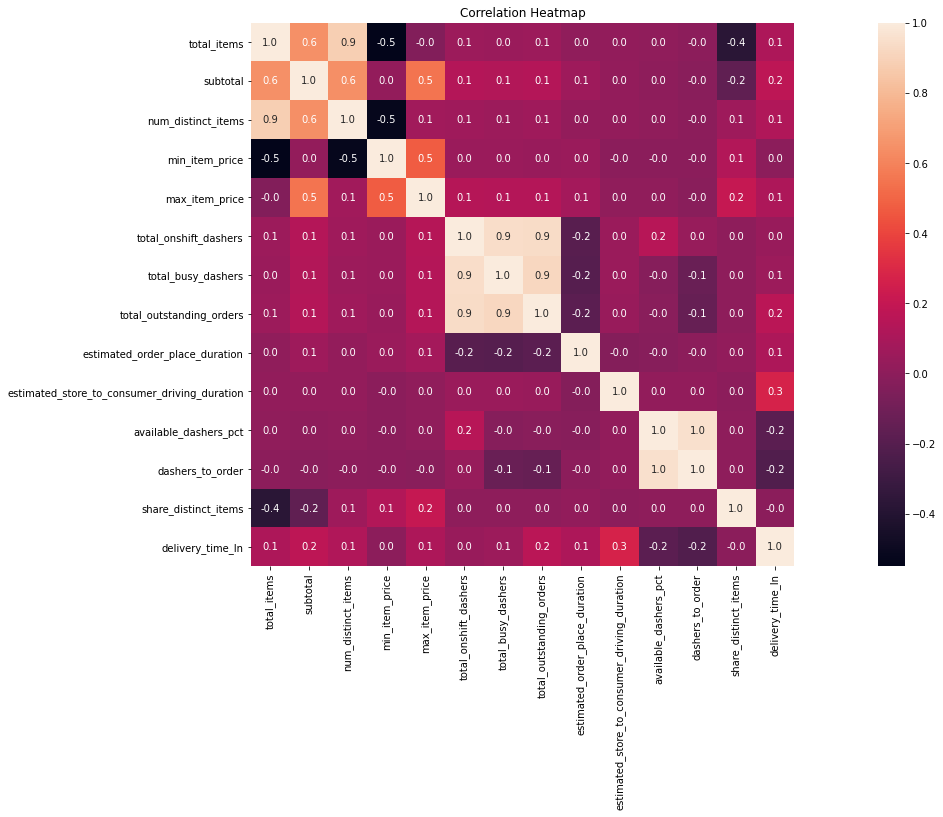

In [341]:
#collect numeric columns
cols_numeric_nooutlier= [ f for f in df_copy_nodup.columns if df_copy_nodup.dtypes[ f ] != "object"]
data_forheatmap_nooutlier=df_copy_nodup[cols_numeric_nooutlier]

corr = data_forheatmap_nooutlier.corr()
plt.subplots(figsize=(30,10))
plt.title('Correlation Heatmap');
sns.heatmap( corr, square=True, annot=True, fmt=".1f" )  

"""Conclusions: only a few variables have somewhat sizable corr. with the target 
while there are correlations among the variables
share_distinct_items min_item_price very low linear association"""

'some form of relationship even for min. item price\nUse df_nodup to appy minmax transformation'

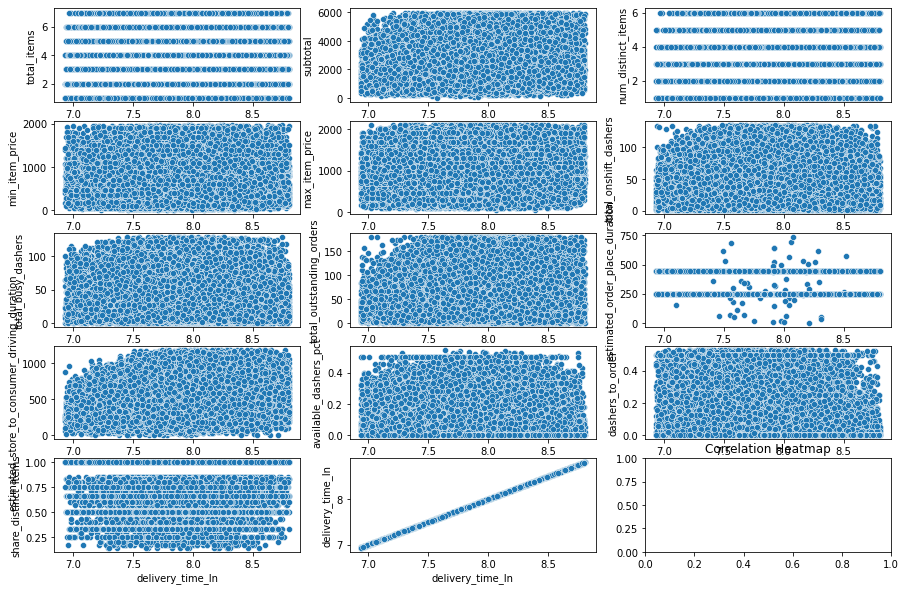

In [342]:
"""scatter plot and correlation of continuous variables to identify some relationship od lack thereof"""

fig, ax = plt.subplots(5, 3, figsize=(15, 10))
for var, subplot in zip(cols_numeric_univariate, ax.flatten()):    
    sns.scatterplot(x='delivery_time_ln', y=var, data=data_forheatmap_nooutlier, ax=subplot);
plt.savefig('file_no_outliers.png')
plt.title('Correlation Heatmap');
"""some form of relationship even for min. item price
Use df_nodup to appy minmax transformation"""

In [309]:

from sklearn.preprocessing import MinMaxScaler
min_max_columns=['total_items', 'subtotal','num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration']
df_part1=df_copy_nodup.drop(columns=min_max_columns)
df_part2=df_copy_nodup[min_max_columns]
df_part2=min_max_scaler.fit_transform(df_part2)
df_part2 = pd.DataFrame(df_part2, columns = min_max_columns)
df_comb=pd.concat([df_part1,df_part2])
df_new=df_comb




In [312]:
column_1=df_new['available_dashers_pct']
column_2=df_new['max_item_price']
correlation = column_1.corr(column_2)
correlation

nan

'Conclusions: only a few variables have somewhat sizable corr. with the target \nwhile there are correlations among the variables\nshare_distinct_items min_item_price very low linear association'

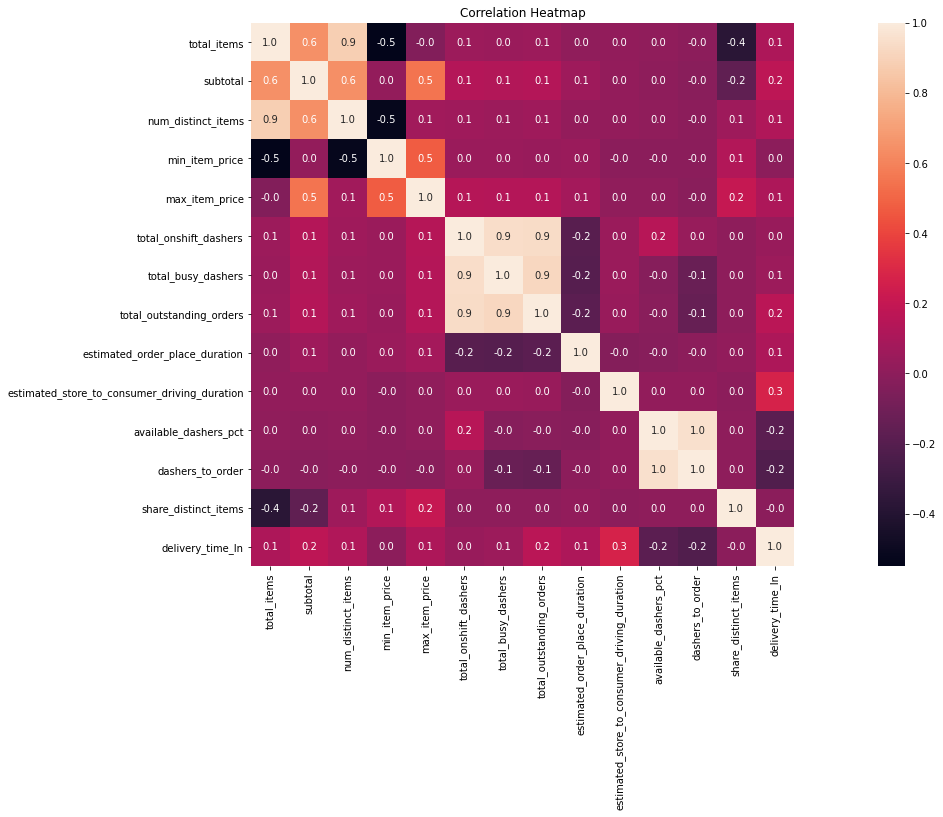

In [319]:
#collect numeric columns
cols_numeric= [ f for f in df_copy_nodup.columns if df_copy_nodup.dtypes[ f ] != "object"]
data_forheatmap_nooutlier=df_copy_nodup[cols_numeric]

corr = data_forheatmap_nooutlier.corr()
plt.subplots(figsize=(30,10))
plt.title('Correlation Heatmap');
sns.heatmap( corr, square=True, annot=True, fmt=".1f" )  

"""Conclusions: only a few variables have somewhat sizable corr. with the target 
while there are correlations among the variables
share_distinct_items min_item_price very low linear association"""

In [320]:
# Define the target variable and Find correlations with the target and sort
#Create the target variable
#import datetime
#df_nodup['actual_delivery_time']=df_nodup['actual_delivery_time'].astype('datetime64[ns]')
#df_nodup['created_at']=df_nodup['created_at'].astype('datetime64[ns]')
#df_nodup['delivery_time']=(df_nodup['actual_delivery_time']-df_new['created_at']).astype('timedelta64[s]')

correlations = data_forheatmap_nooutlier.corr()['delivery_time_ln'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

"""Conclusion: 
    Drop min_item_price, available dashers,share_distinct_items
    Define share of dintinct items and drop total items """



Most Positive Correlations:
 dashers_to_order                               -0.218873
available_dashers_pct                          -0.180231
share_distinct_items                           -0.009845
min_item_price                                  0.001097
total_onshift_dashers                           0.043644
total_busy_dashers                              0.050901
estimated_order_place_duration                  0.112341
total_items                                     0.114490
max_item_price                                  0.115399
num_distinct_items                              0.124051
total_outstanding_orders                        0.161496
subtotal                                        0.175658
estimated_store_to_consumer_driving_duration    0.267874
delivery_time_ln                                1.000000
Name: delivery_time_ln, dtype: float64

Most Negative Correlations:
 dashers_to_order                               -0.218873
available_dashers_pct                          

'Conclusion: \n    Drop min_item_price, available dashers,share_distinct_items\n    Define share of dintinct items and drop total items '

'some form of relationship even for min. item price\nUse df_nodup to appy minmax transformation'

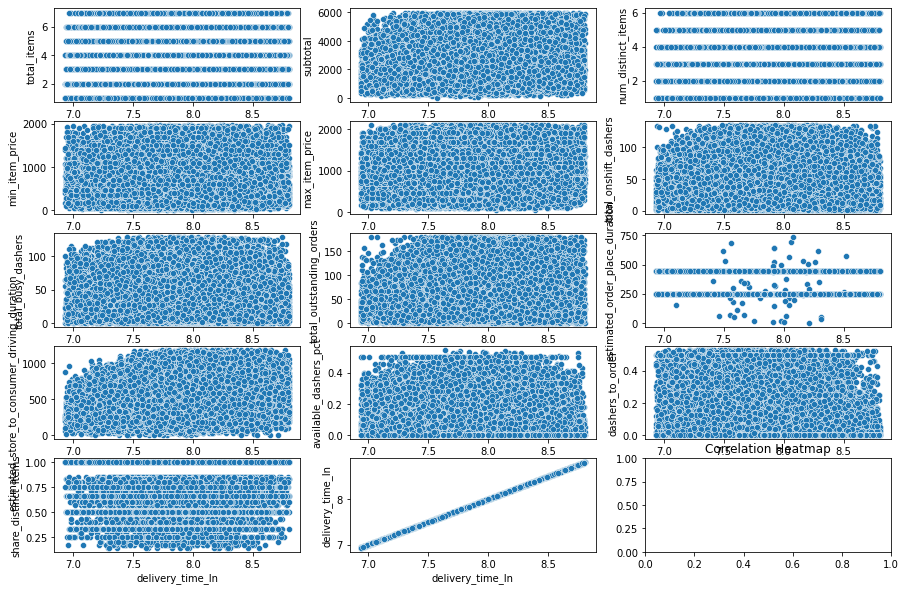

In [321]:
"""scatter plot and correlation of continuous variables to identify some relationship od lack thereof"""

fig, ax = plt.subplots(5, 3, figsize=(15, 10))
for var, subplot in zip(cols_numeric_univariate, ax.flatten()):    
    sns.scatterplot(x='delivery_time_ln', y=var, data=data_forheatmap_nooutlier, ax=subplot);
plt.savefig('file_no_outliers.png')
plt.title('Correlation Heatmap');
"""some form of relationship even for min. item price
Use df_nodup to appy minmax transformation"""

In [324]:
from sklearn.preprocessing import MinMaxScaler
min_max_columns=['available_dashers_pct', 'dashers_to_order','share_distinct_items', 'total_items', 'subtotal','num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration']
df_part1_with_outlier=df_nodup.drop(columns=min_max_columns)
df_part2_with_outlier=df_nodup[min_max_columns]
df_part2_with_outlier=min_max_scaler.fit_transform(df_part2_with_outlier)
df_part2_with_outlier = pd.DataFrame(df_part2_with_outlier, columns = min_max_columns)
df_comb_with_outlier=pd.concat([df_part1_with_outlier,df_part2_with_outlier])
df_comb_with_outlier.describe()

,delivery_time_ln,available_dashers_pct,dashers_to_order,share_distinct_items,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,197248.000000,136447.000000,136198.000000,197255.000000,197255.000000,197076.000000,197255.000000,194707.000000,197248.000000,177357.000000,176801.000000,176838.000000,197161.000000,196720.000000
mean,7.891545,0.151173,0.009702,0.902233,0.005358,0.098685,0.087950,0.047229,0.075623,0.263098,0.272744,0.205672,0.112726,0.260853
std,0.364085,0.172152,0.020695,0.182906,0.006504,0.067276,0.085806,0.035345,0.038117,0.201608,0.208310,0.184889,0.033153,0.105084
min,4.615121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.651596,0.013980,0.000387,0.831281,0.002439,0.051314,0.000000,0.020342,0.051065,0.100000,0.098039,0.059859,0.091445,0.182559
50%,7.886081,0.088542,0.003175,1.000000,0.004878,0.080774,0.052632,0.040683,0.071204,0.217647,0.228758,0.144366,0.091445,0.260182
75%,8.125927,0.236111,0.010782,1.000000,0.007317,0.124926,0.105263,0.064562,0.091685,0.382353,0.405229,0.299296,0.163348,0.335889
max,15.957558,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


'Conclusions: only a few variables have somewhat sizable corr. with the target \nwhile there are correlations among the variables\nshare_distinct_items min_item_price very low linear association'

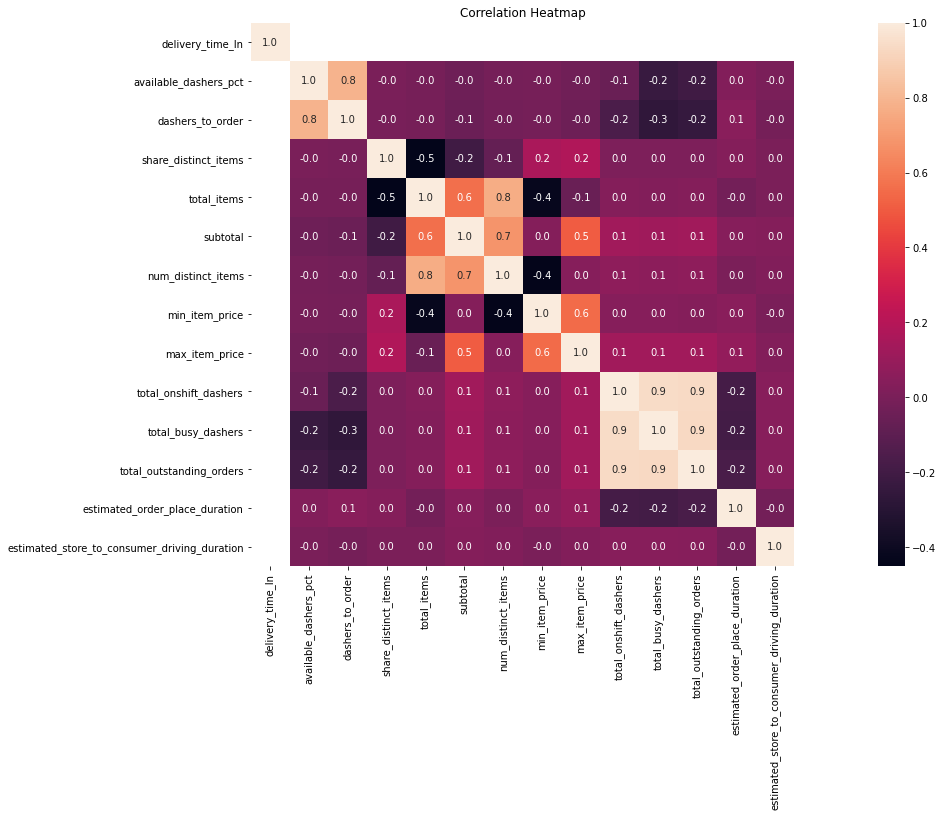

In [327]:
#collect numeric columns
cols_numeric_minmax= [ f for f in df_comb_with_outlier.columns if df_comb_with_outlier.dtypes[ f ] != "object"]
data_forheatmap_minmax=df_comb_with_outlier[cols_numeric_minmax]

corr = data_forheatmap_minmax.corr()
plt.subplots(figsize=(30,10))
plt.title('Correlation Heatmap');
sns.heatmap( corr, square=True, annot=True, fmt=".1f" )  

"""Conclusions: only a few variables have somewhat sizable corr. with the target 
while there are correlations among the variables
share_distinct_items min_item_price very low linear association"""

'some form of relationship even for min. item price\nUse df_nodup to appy minmax transformation'

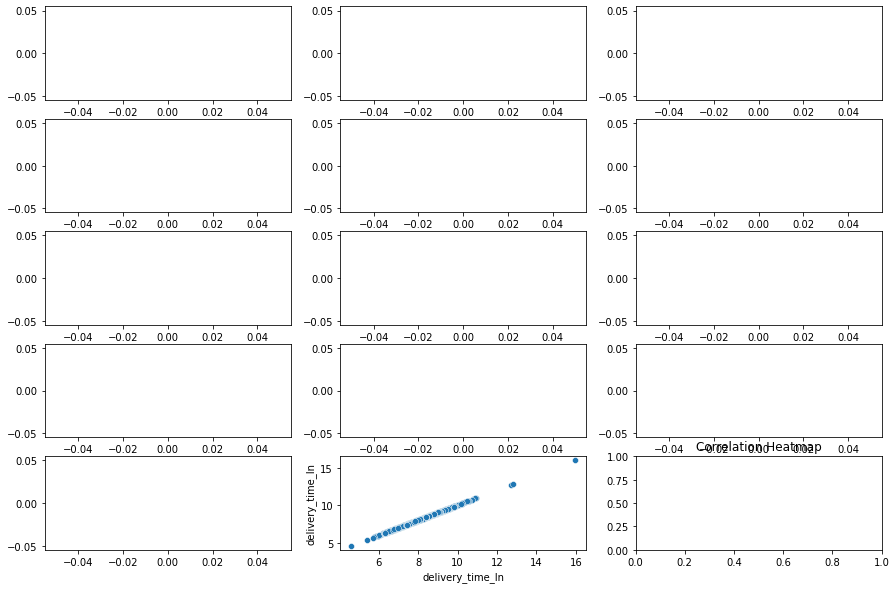

In [328]:
"""scatter plot and correlation of continuous variables to identify some relationship od lack thereof"""

fig, ax = plt.subplots(5, 3, figsize=(15, 10))
for var, subplot in zip(cols_numeric_univariate, ax.flatten()):    
    sns.scatterplot(x='delivery_time_ln', y=var, data=data_forheatmap_minmax, ax=subplot);
plt.savefig('file_min_max.png')
plt.title('Correlation Heatmap');
"""some form of relationship even for min. item price
Use df_nodup to appy minmax transformation"""

'some skewed variables'

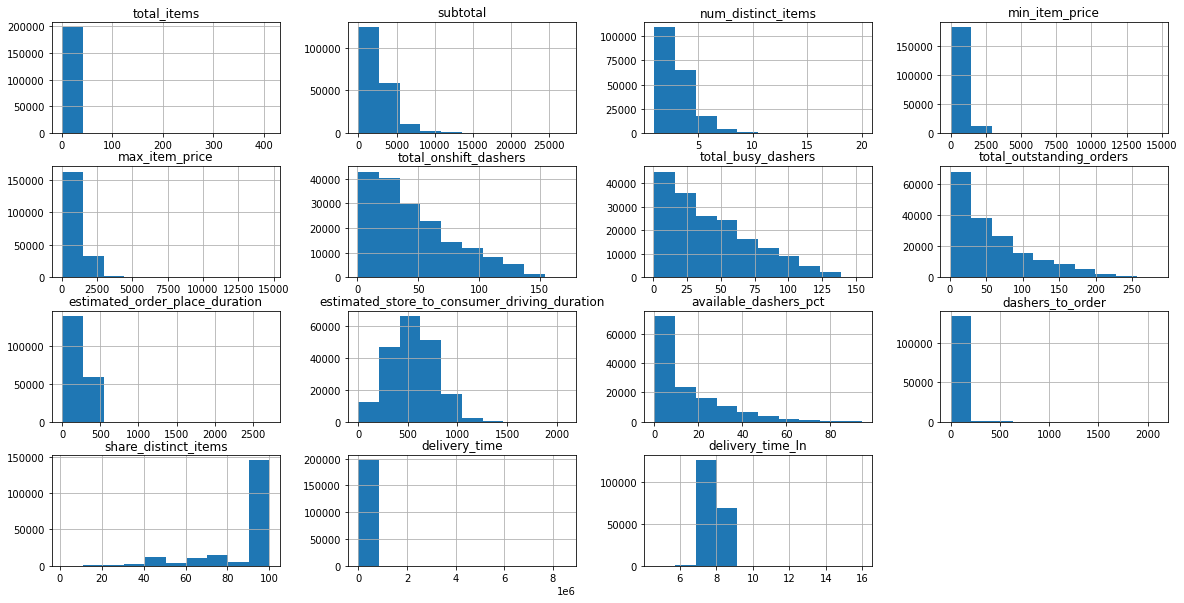

In [13]:
"""See numerical variables"""
df_nodup[cols_numeric_univariate].hist(figsize=(20, 10));
plt.savefig('file_name2.png')
plt.title('Correlation Heatmap');
"some skewed variables"

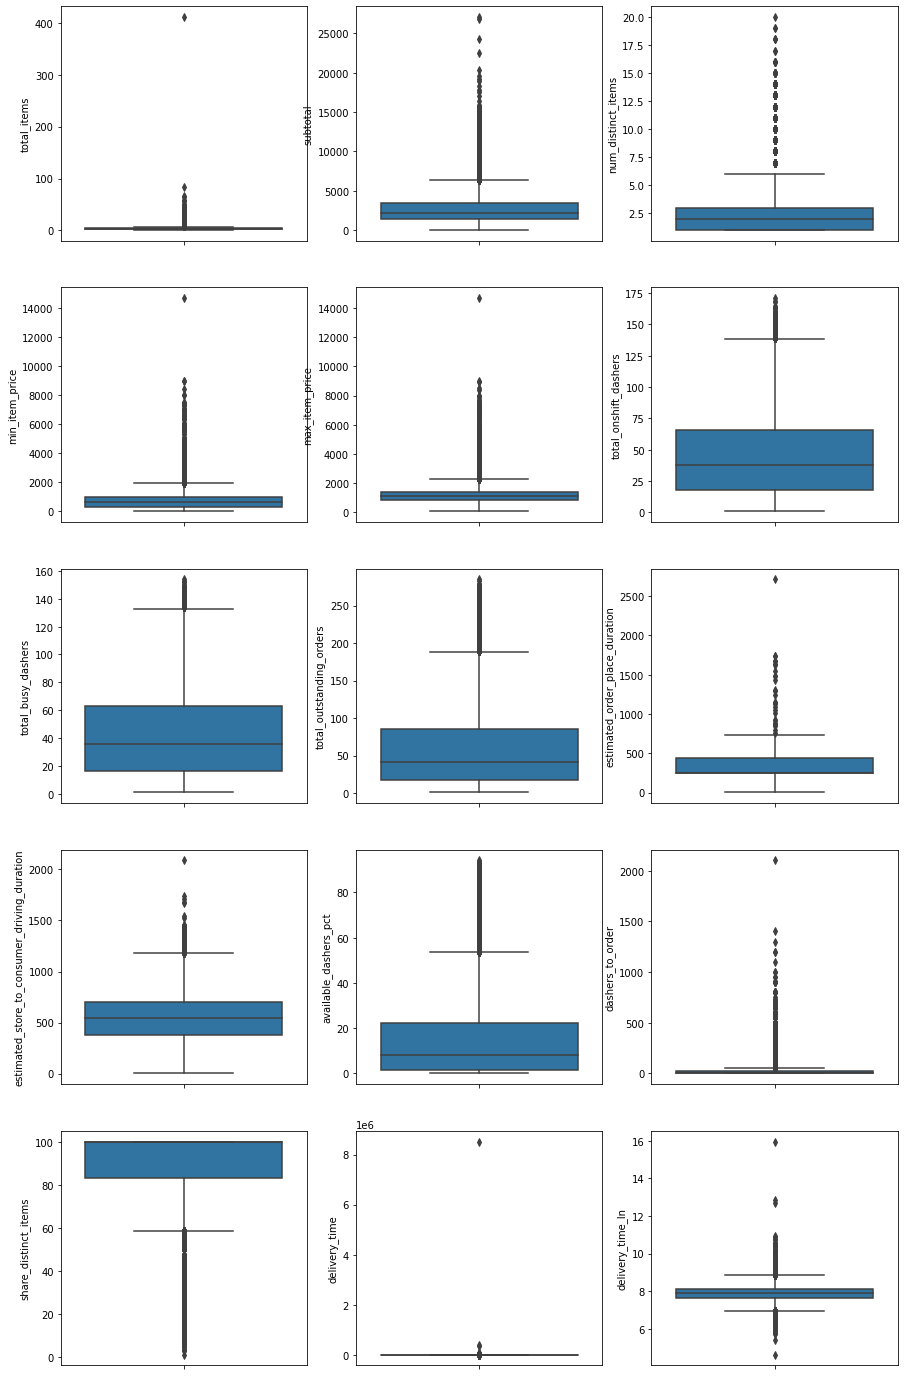

In [12]:
df_for_boxplot_univariate=df_nodup[cols_numeric_univariate]
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for var, subplot in zip(cols_numeric_univariate, ax.flatten()):
    sns.boxplot(y=df_for_boxplot_univariate[var], data=df_for_boxplot_univariate, ax=subplot)
#plt.title('Correlation Heatmap');  

In [33]:
cols_numeric_univariate

['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'available_dashers_pct',
 'dashers_to_order',
 'share_distinct_items',
 'delivery_time',
 'delivery_time_ln']

In [41]:
#backup_cols=cols_numeric_univariate
#backup_cols.remove('delivery_time_ln')

backup_cols=['total_items', 'subtotal']
from scipy import stats

for var in backup_cols:
    IQR = stats.iqr(df_nodup[var], interpolation = 'midpoint')
    Q1=df_nodup[var].quantile(0.25)
    Q3=df_nodup[var].quantile(0.75)
    Lower_Whisker = Q1-(1.5)*IQR
    Upper_Whisker = Q3+(1.5)*IQR
    df_nodup = df_nodup[df_nodup[var]< Upper_Whisker]



In [28]:

from scipy import stats
IQR = stats.iqr(df_nodup.total_items, interpolation = 'midpoint')

Q1=df_nodup.total_items.quantile(0.25)
Q3=df_nodup.total_items.quantile(0.75)
Lower_Whisker = Q1-(1.5)*IQR
Upper_Whisker = Q3+(1.5)*IQR
print(Lower_Whisker, Upper_Whisker)

df_nodup = df_nodup[df_nodup.total_items< Upper_Whisker]


-1.0 7.0
(197255, 23)
(182656, 23)


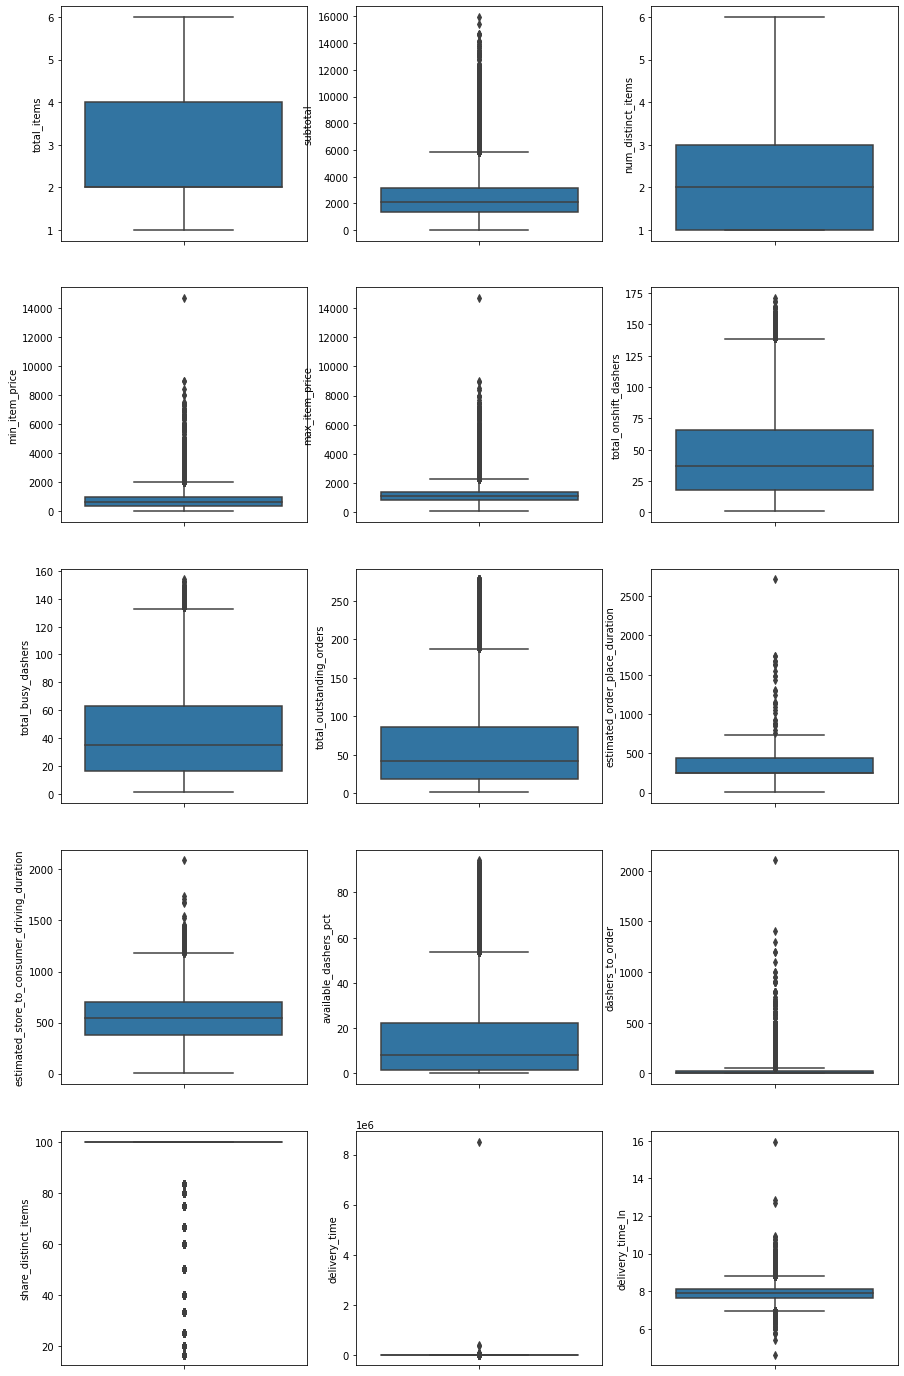

In [31]:
df_boxplot_nooutlier=df_nodup_nooutlier[cols_numeric_univariate]
fig, ax = plt.subplots(5, 3, figsize=(15, 25))
for var, subplot in zip(cols_numeric_univariate, ax.flatten()):
    sns.boxplot(y=df_boxplot_nooutlier[var], ax=subplot)
#plt.title('Correlation Heatmap');  

In [18]:
type(Q1)

NameError: name 'Q1' is not defined

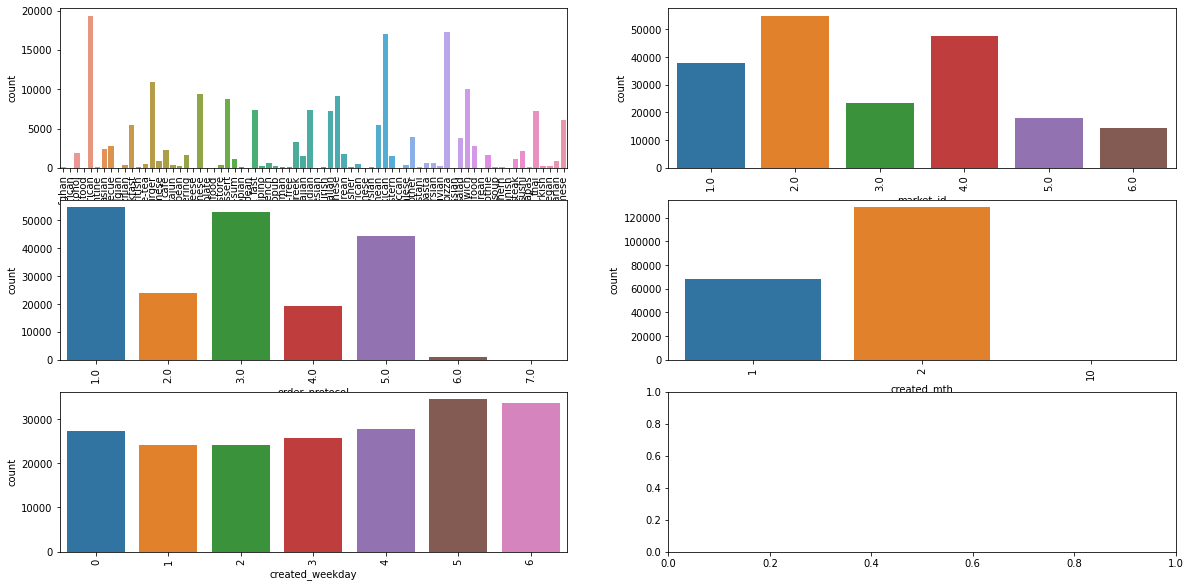

In [14]:
"""See Categorical variables"""

df_nodup_categorical=df_nodup[categorical]
fig, ax = plt.subplots(3, 2, figsize=(20, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_nodup_categorical[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
 #plt.title('Correlation Heatmap');       
        

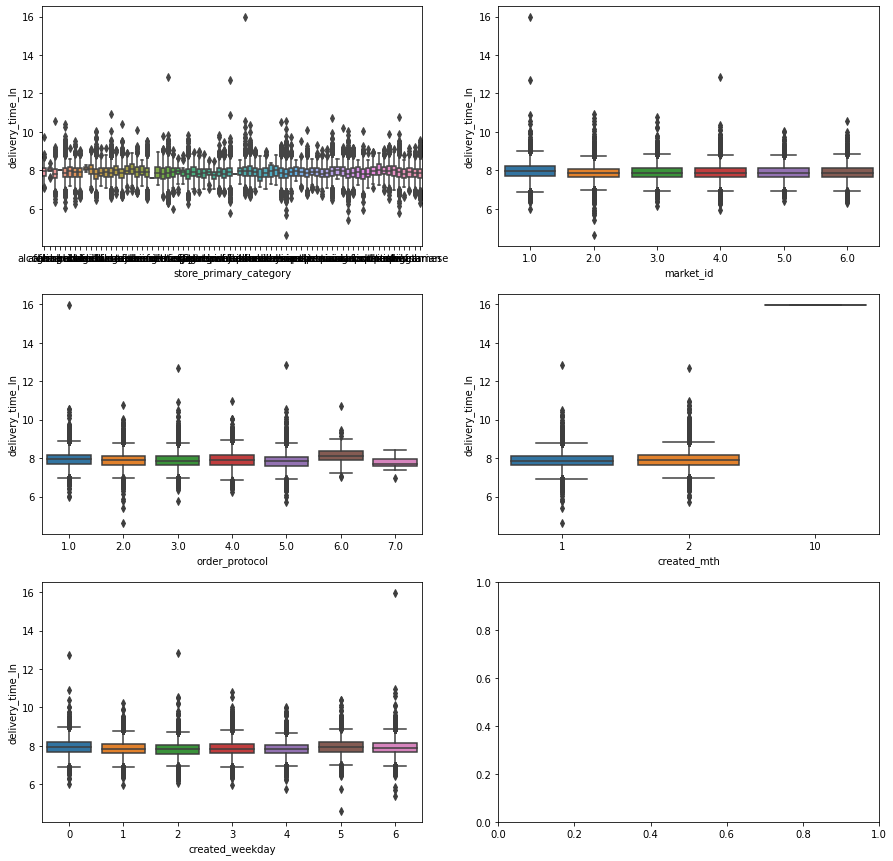

In [15]:
df_for_boxplot=pd.concat([df_nodup_categorical,df_nodup['delivery_time_ln']], axis=1)
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for var, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(x=var, y='delivery_time_ln', data=df_for_boxplot, ax=subplot)
#plt.title('Correlation Heatmap');    
    
    "some buckets display different distribution: for created weekday and order protocol"

In [16]:
"""2) Correlated Variables: Identify and Remove Correlated Variables"""

#collect numeric columns
df_numXonly=df_nodup[cols_numeric_univariate]
#df['available_dashers_pct']=(1-df['total_busy_dashers']/df['total_onshift_dashers'])
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = df_numXonly.corr().abs()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print('Columns are {}:'.format(to_drop))
#dfnew1_numXonly = dfnew1_numXonly.drop(columns = to_drop)
print(upper)


#Conclusion: Remove total_busy_dashers,total_onshift_dashers

There are 2 columns to remove.
Columns are ['total_busy_dashers', 'total_outstanding_orders']:
                                              total_items  subtotal  \
total_items                                           NaN  0.558781   
subtotal                                              NaN       NaN   
num_distinct_items                                    NaN       NaN   
min_item_price                                        NaN       NaN   
max_item_price                                        NaN       NaN   
total_onshift_dashers                                 NaN       NaN   
total_busy_dashers                                    NaN       NaN   
total_outstanding_orders                              NaN       NaN   
estimated_order_place_duration                        NaN       NaN   
estimated_store_to_consumer_driving_duration          NaN       NaN   
available_dashers_pct                                 NaN       NaN   
dashers_to_order                                     

In [17]:

miss_value_pct=(df_nodup.isnull().sum()/len(df_nodup)).sort_values(ascending=False)
print(miss_value_pct)
df_miss_cols_gt65pct=list(miss_value_pct.index[miss_value_pct>0.65])
df_cols2impute=list(miss_value_pct.index[miss_value_pct>0])
if not df_miss_cols_gt65pct:   
  print("No Feature with more than 65% missing values")
else:
 print("Generate df_nomiss")   
 df_nomiss_gt65pct=df_features_only.drop(column=df_miss_cols_gt65pct, axis=1)   
if df_cols2impute:
  print("There are {} variables to impute".format(len(df_cols2impute)) )
  print("Columns for Imputing are: " , df_cols2impute)  


dashers_to_order                                0.309533
available_dashers_pct                           0.308271
total_busy_dashers                              0.103693
total_outstanding_orders                        0.103506
total_onshift_dashers                           0.100875
store_primary_category                          0.024121
min_item_price                                  0.012917
order_protocol                                  0.005044
market_id                                       0.005004
estimated_store_to_consumer_driving_duration    0.002712
subtotal                                        0.000907
estimated_order_place_duration                  0.000477
max_item_price                                  0.000035
actual_delivery_time                            0.000035
delivery_time                                   0.000035
delivery_time_ln                                0.000035
num_distinct_items                              0.000000
created_at                     

In [343]:
"""Impute category type variables with most frequent value before the Encoding Step"""

#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')
cols_impute_freq=['order_protocol','market_id' , 'store_primary_category']
df_copy_nodup[cols_impute_freq] = my_imputer.fit_transform(df_copy_nodup[cols_impute_freq])


In [33]:
df_nodup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197255 entries, 0 to 197254
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197255 non-null  float64       
 1   created_at                                    197255 non-null  datetime64[ns]
 2   actual_delivery_time                          197248 non-null  datetime64[ns]
 3   store_id                                      197255 non-null  category      
 4   store_primary_category                        197255 non-null  object        
 5   order_protocol                                197255 non-null  float64       
 6   total_items                                   197255 non-null  float64       
 7   subtotal                                      197076 non-null  float64       
 8   num_distinct_items                            197255 n

In [355]:
categorical=['store_primary_category', 'market_id', 'order_protocol', 'created_mth']

In [358]:
vars=df_copy_nodup['store_primary_category'].unique() 
vars.shape #so choose label encoding


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for var in categorical:
    print(var)
    le.fit(df_copy_nodup[var])
    df_copy_nodup[var]=le.transform(df_copy_nodup[var])



store_primary_category
market_id
order_protocol
created_mth


In [359]:
#https://stackoverflow.com/questions/36285155/pandas-get-dummies
from sklearn.preprocessing import OneHotEncoder    
df_one_hot=pd.get_dummies(df_copy_nodup, columns = ['created_weekday'])

df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151544 entries, 2 to 197254
Data columns (total 28 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     151544 non-null  int64         
 1   created_at                                    151544 non-null  datetime64[ns]
 2   actual_delivery_time                          151539 non-null  datetime64[ns]
 3   store_id                                      151544 non-null  category      
 4   store_primary_category                        151544 non-null  int64         
 5   order_protocol                                151544 non-null  int64         
 6   total_items                                   151544 non-null  float64       
 7   subtotal                                      151406 non-null  float64       
 8   num_distinct_items                            151544 n

In [53]:
df_nodup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197255 entries, 0 to 197254
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197255 non-null  int64         
 1   created_at                                    197255 non-null  datetime64[ns]
 2   actual_delivery_time                          197248 non-null  datetime64[ns]
 3   store_id                                      197255 non-null  category      
 4   store_primary_category                        197255 non-null  int64         
 5   order_protocol                                197255 non-null  int64         
 6   total_items                                   197255 non-null  float64       
 7   subtotal                                      197076 non-null  float64       
 8   num_distinct_items                            197255 n

In [23]:
from sklearn.preprocessing import OneHotEncoder   
df_test = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
                   'C': [1, 2, 3]})
df_test=pd.get_dummies(df_test, prefix=['col1', 'col2'])
df_test

,C,col1_a,col1_b,col2_a,col2_b,col2_c
0,1,1,0,0,1,0
1,2,0,1,1,0,0
2,3,1,0,0,0,1


In [360]:
"""Drop unnecessay variables and impute for remaining missing values"""
cols_nouse_model=['store_id', 'created_mth', 'total_onshift_dashers', 'total_busy_dashers', 'created_at','actual_delivery_time']
df_model_vars=df_one_hot.drop(columns=cols_nouse_model)
cols_impute_mean=['subtotal', 'estimated_order_place_duration', 'min_item_price', 'max_item_price', 'dashers_to_order', 'available_dashers_pct', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration', 'delivery_time_ln']
df_model_vars[cols_impute_mean] = my_imputer.fit_transform(df_model_vars[cols_impute_mean])

In [351]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


plt.style.use('ggplot')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [62]:
df_model_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197255 entries, 0 to 197254
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     197255 non-null  int64  
 1   store_primary_category                        197255 non-null  int64  
 2   order_protocol                                197255 non-null  int64  
 3   total_items                                   197255 non-null  float64
 4   subtotal                                      197255 non-null  float64
 5   num_distinct_items                            197255 non-null  float64
 6   min_item_price                                197255 non-null  float64
 7   max_item_price                                197255 non-null  float64
 8   total_outstanding_orders                      197255 non-null  float64
 9   estimated_order_place_duration                19

In [354]:
df_model_vars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151544 entries, 2 to 197254
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     151544 non-null  float64
 1   store_primary_category                        151544 non-null  object 
 2   order_protocol                                151544 non-null  float64
 3   total_items                                   151544 non-null  float64
 4   subtotal                                      151544 non-null  float64
 5   num_distinct_items                            151544 non-null  float64
 6   min_item_price                                151544 non-null  float64
 7   max_item_price                                151544 non-null  float64
 8   total_outstanding_orders                      151544 non-null  float64
 9   estimated_order_place_duration                15

In [361]:
"""Prepare for modeling"""


model_X_list=list(df_model_vars.columns)
model_X_list.remove('delivery_time_ln')
X=df_model_vars[model_X_list]
Y=df_model_vars['delivery_time_ln']

# Split data into 70% train and 30% test
SEED = 12345
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3,random_state=SEED)
rf = RandomForestRegressor(max_depth=10,n_estimators=50, min_samples_leaf=2, random_state=SEED,verbose=2,n_jobs=-1)
rf.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50building tree 24 of 50

building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.4s finished


RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=50,
                      n_jobs=-1, random_state=12345, verbose=2)

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197255 entries, 0 to 197254
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     197255 non-null  int64  
 1   store_primary_category                        197255 non-null  int64  
 2   order_protocol                                197255 non-null  int64  
 3   total_items                                   197255 non-null  float64
 4   subtotal                                      197076 non-null  float64
 5   num_distinct_items                            197255 non-null  float64
 6   min_item_price                                197255 non-null  float64
 7   max_item_price                                197255 non-null  float64
 8   total_outstanding_orders                      197255 non-null  float64
 9   estimated_order_place_duration                19

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138078 entries, 70176 to 77285
Data columns (total 15 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     138078 non-null  int64  
 1   store_primary_category                        138078 non-null  int64  
 2   order_protocol                                138078 non-null  int64  
 3   total_items                                   138078 non-null  float64
 4   subtotal                                      137948 non-null  float64
 5   num_distinct_items                            138078 non-null  float64
 6   min_item_price                                138078 non-null  float64
 7   max_item_price                                138074 non-null  float64
 8   total_outstanding_orders                      138078 non-null  float64
 9   estimated_order_place_duration               

In [362]:


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

rf_accuracy=evaluate(rf,X_test,y_test )


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


Model Performance
Average Error: 0.2396 degrees.
Accuracy = 96.95%.


In [ ]:
from matplotlib import pyplot
# get importance
importances_rf = rf.feature_importances_
print(type(importances_rf))
print(importances_rf)
indices = np.argsort(importances_rf)
list_feature_names = []
for var in indices:
    list_feature_names.append(X_train.columns[var])
list_feature_names

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances_rf[indices],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train.shape[1]), list_feature_names)
plt.ylim([-1, X_train.shape[1]])
plt.show()

"""Conclusion: drop the last three"""

In [ ]:
drop_low_importance=['share_distinct_items', 'total_items', 'num_distinct_items']
X_new=X.drop(columns=drop_low_importance)


# Split data into 70% train and 30% test
SEED = 11111
X_train, X_test, y_train, y_test = train_test_split(X_new,Y, test_size=0.3,random_state=SEED)
rf_new = RandomForestRegressor(max_depth=10,n_estimators=50, min_samples_leaf=2, random_state=SEED,verbose=2,n_jobs=-1)
rf_new.fit(X_train, y_train)

In [ ]:
rf_accuracy=evaluate(rf_new,X_test,y_test )

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_new)
shap.summary_plot(shap_values, X_new, plot_type="bar")

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'max_features': max_features,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

rf_3 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_3_random = RandomizedSearchCV(estimator = rf_3, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_3_random.fit(X_train, y_train)


In [ ]:
best_random = rf_3_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
"""
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sorted_importances_rf = np.sort(importances_rf)
pyplot.bar([x for x in range(len(sorted_importances_rf))], sorted_importances_rf)
pyplot.show()
"""

In [ ]:
# Setup the Imputation transformer: imp
my_imputer_numeric = SimpleImputer(missing_values= np.nan, strategy='mean')
# Instantiate the SVC classifier: clf
rf = RandomForestRegressor(n_estimators=400,
min_samples_leaf=0.12,
random_state=SEED)

# Setup the pipeline with the required steps: steps
steps = [('imputation', my_imputer_numeric),
        ('RF', rf)]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
"""random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
"""
parameters = {'max_features': max_features,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

#clf_3 = RandomForestClassifier(max_depth=10,n_estimators=50, min_samples_leaf=2, random_state=0,verbose=2,n_jobs=-1)
# Instantiate the GridSearchCV object: cv
RF_cv = GridSearchCV(pipeline,param_grid=parameters, cv=5)

# Fit to the training set
RF_cv.fit(X_train, y_train)

"""
# Setup the pipeline steps: steps
steps = [('imputation', Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
        ('SVM', SVC())]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the train set
pipeline.fit(Xdummies,Y)
y_pred = pipeline.predict(Xdummies)
# Compute metrics
print(classification_report(y, y_pred))

#ALTERNATIVELY
# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xdummies,Y, test_size=0.2, random_state=21)

# Instantiate the GridSearchCV object: cv
SVM_cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

# Fit to the training set
SVM_cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
SVM_cv.score(X_test, y_test)
print(classification_report(y_test, y_pred))
SVM_cv.best_params_"""

In [ ]:
"""remaining:
chi-square test
label encoding all categorical
missing value imputation
correl
anomalies: outliers-invalid values
bin all numerical var
variable importance via random forest
decide on variables to keep
rf again and xgboost
knn
rf
xgboost
one-hot encpding weekday
create am/pm
pipeline and hypertuning
plot for the final tree
plot of variable importance"""

In [ ]:
"""more if possible

cluster analysis"""